# Acquisition functions in Bayesian optimization

The acquisition $\alpha_t(x)$ quantifies how useful a point $x$ is towards finding the global optimum of the objective $y^*$, thus we want to maximize it at each step $t=1 ... T$.  
$D_t = \{(x_1, y_1) ... (x_t, y_t)\}$ is the data, of which $x^+$ is the location of the best point $y^+$ observed so far.  

The values for the objective function are typically modelled by $y_t = f(x_t) + \epsilon_t$ where the $\epsilon_t \sim N(0,\sigma)$ and $f$ is a probabilistic surrogate model. In case of a Gaussian Process the posterior predictive distribution can be expressed in terms of a predictive mean $\mu$ and variance $\sigma^2$.

### Single objective
* [Confidence bound](#Confidence-bound)
* [Probability of improvement](#Probability-of-improvement)
* [Expected improvement](#Expected-improvement)
* [Scaled expected improvement](#Scaled-expected-improvement)
* [Top-two expected improvement](#Top-two-expected-improvement)
* [Uncertainty sampling](#Uncertainty-sampling)
* [Thompson sampling](#Thompson-sampling)
* [Mutual information](#Mutual-information)
* [Entropy search](#Entropy-search)
* [Predictive entropy search](#Predictive-entropy-search)
* [Max-value entropy search](#Max-value-entropy-search)
* [Knowledge gradient](#Knowledge-gradient)
* [GLASSES](#GLASSES)
* [Estimation strategy](#Estimation-strategy)

### Multiple objectives
In the case of multiple objectives there are two approaches: 
1. multi-objective scalarization with either a-priori chosen or random weights, together with a single-objective acquisition 
2. multi-objective acquistions that aim for improving the knowledge of the Pareto front.

Regarding 1. the same scalarizations as in multi-objective optimization may be applied. An overview of scalarization methods in the context of Bayesian optimization is given in [Chugh 2019 - Scalarizing Functions in Bayesian Multiobjective Optimization](https://arxiv.org/abs/1904.05760).

Regarding 2. there is a growing list of multi-objective acquistions:
* [Expected hypervolume improvement](#Expected-hypervolume-improvement) 
* Expected maximin [EMmi]: [Svenson+ 2016 - Multiobjective optimization of expensive-to-evaluate deterministic computer simulator models](https://www.sciencedirect.com/science/article/pii/S0167947315001991)
* Probability of improvement, Expected Euclidean improvement [Keane 2012 - Statistical Improvement Criteria for Use in Multiobjective Design Optimization](https://arc.aiaa.org/doi/abs/10.2514/1.16875?journalCode=aiaaj)
* Predictive entropy search [Garrido-Merchan+ 2019 - Predictive Entropy Search for Multi-objective Bayesian Optimization with Constraints](https://www.sciencedirect.com/science/article/pii/S0925231219308525)
* Uncertainty reduction [Picheny 2015 - Multiobjective optimization using Gaussian process emulators via stepwise uncertainty reduction](https://link.springer.com/article/10.1007/s11222-014-9477-x)
* Thompson sampling [TS]: [Bradford 2018 - Efficient multiobjective optimization employing Gaussian
processes, spectral sampling and a genetic algorithm](https://doi.org/10.1007/s10898-018-0609-2)
* Chimera
* Expected R2 improvement [ER2I]: [Deutz 2019 - Expected R2 Indicator Improvement as an Infill Criterion in Bi-objective Bayesian Optimization](https://link.springer.com/chapter/10.1007/978-3-030-12598-1_29)
* Uncertainty sampling, Probability of Joint Exceedance, Hyperplane probability of improvement, Probability non-dominated: [Zachary+ (2019) Assessing the Frontier: Active Learning, Model Accuracy, and Multi-objective Materials Discovery and Optimization](https://arxiv.org/abs/1911.03224)

### Example
In the following we consider the 1-dimensional Forrester function as the unknown black-box function which we wish to minimize.
We already sampled 4 points and use a GP with a Matern 5/2 kernel as surrogate model.

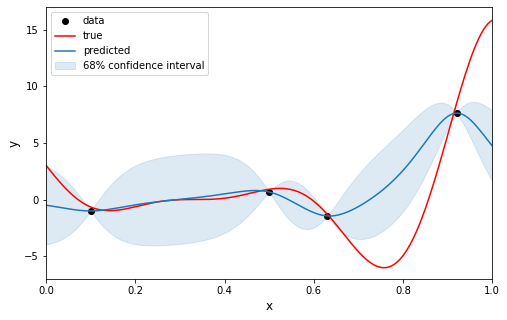

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import GPy
import GPyOpt

# set up unknown test function
σ_noise = 0.5
np.random.seed(1337)
f_true = GPyOpt.objective_examples.experiments1d.forrester()
f_noisy = GPyOpt.objective_examples.experiments1d.forrester(sd=σ_noise)

X = np.linspace(0, 1, 201).reshape(201, 1)
Y = f_true.f(X)

# observed data
Xd = np.array([0.1, 0.5, 0.63, 0.92]).reshape([4, 1])
Yd = f_noisy.f(Xd)
best = Yd.min()

# fit Gaussian process
gp = GPy.models.GPRegression(Xd, Yd, kernel=GPy.kern.Matern52(1))
gp.optimize_restarts(10, verbose=0)

# GP posterior
μ, σ = gp.predict(X)
σ = σ ** 0.5

def plot(plot_true=False, acquisition=None):
    fig, ax = plt.subplots(1, figsize=(8, 5))
    ax.plot(Xd, Yd, 'ko', label='data')
    if plot_true:
        ax.plot(X, Y, 'r', label='true')
    ax.plot(X, μ, 'C0', label='predicted')
    ax.fill_between(X[:,0], (μ - σ)[:,0], (μ + σ)[:,0], alpha=.15, color='C0', label='68% confidence interval')
    ax.set(xlabel='x', ylabel='y', xlim=(0, 1), ylim=(-7, 17))
    ax.legend(loc='upper left')
    if acquisition is not None:
        ax2 = ax.twinx()
        ax2.plot(X, acquisition, 'C1', label='acquisition')
        ax2.legend(loc='upper right')
    
plot(True)

## Confidence bound
With confidence bound (CB, [Auer 2002], [Srinivas+ 2010]) the idea is to be optimistic and simply look for the best value within $k-$sigma off the mean. Thus for a minimization problem, we maximize 
\begin{align}
\alpha_\mathrm{CB}(x) = - (\mu(x) - k \sigma(x))
\end{align} 
where $\mu$ and $\sigma$ are the predictive mean and standard deviation, and $k$ controls the exploration.

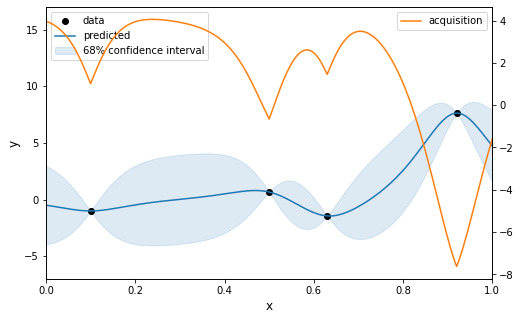

In [34]:
plot(acquisition=-(μ - σ))

## Probability of improvement
Probability of improvement (PI, [Mockus 1974]) selects the point with the highest probability of any improvement with respect to $f^+$ the best value observed so far.
\begin{align}
\alpha_\mathrm{PI}(x) &= \mathbb{P}(I(x) > 0) = \Phi(u) \\
I(x) &= \max(0, f^+ - f(x)) \\
u &= (f^+ - \mu(x)) / \sigma(x)
\end{align}
where $\Phi$ is the standard normal cdf.

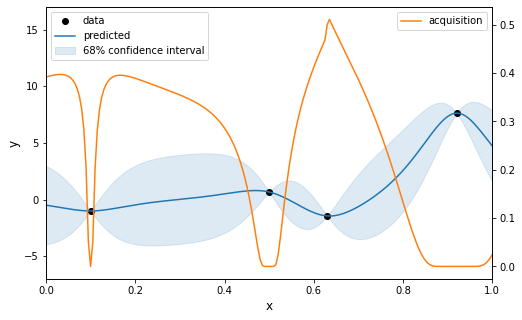

In [36]:
u = (best - μ) / σ
PI = scipy.stats.norm.cdf(u)
plot(acquisition=PI)

## Expected improvement
Instead of looking for any kind of improvement ($I(x) > 0$), expected improvement (EI, [Kushner 1964]) takes the magnitude of the improvement $I(x)$ into account and maximize its expectation value:
\begin{align}
\alpha_\mathrm{EI}(x) = \mathbb{E} [I(x)] = (f^+ - \mu(x)) \Phi(x) + \sigma(x) \phi(x)
\end{align}
where $\Phi$ and $\phi$ are the standard normal cdf and pdf, respectively.

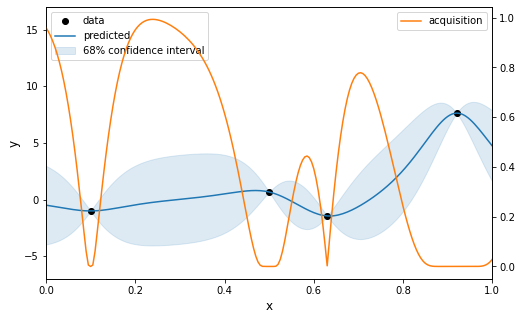

In [10]:
u = (best - μ) / σ
cdf = scipy.stats.norm.cdf(u)
pdf = scipy.stats.norm.pdf(u)
EI = (best - μ) * cdf + σ * pdf

plot(acquisition=EI)

## Scaled expected improvement
Scaled expected improvement (SEI, [Noe 2018]) is a recent modification that takes the uncertainty of the improvement quantifier $I(x)$ into account:
\begin{align}
\mathbb{V}[I(x)] = σ_f^2(x)((u^2 + 1) \Phi(u) + u \phi(u)) − \mathrm{EI}(x)^2
\end{align}
Scaling the expectation value of $I(x)$ by its uncertainty, we arrive at
\begin{align}
\alpha_\mathrm{SEI} = \mathbb{E}[I(x)] / \sqrt{\mathbb{V}[I(x)]}
\end{align}

Comment: At least in this example SEI looks very similar to PI as dividing by the uncertainty of the improvement seems to cancel out the exploration part in EI. The authors claim superior empirical performance compared to both EI and PI on the standard set of low-dimensional optimization functions however ...

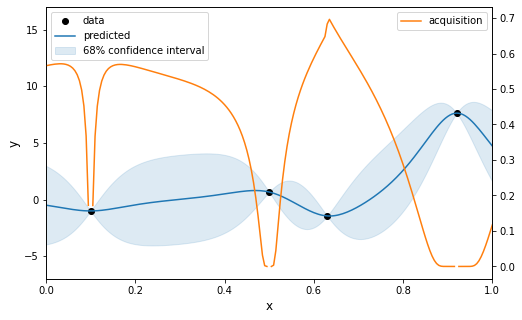

In [11]:
u = (best - μ) / σ
cdf = scipy.stats.norm.cdf(u)
pdf = scipy.stats.norm.pdf(u)
EI = (best - μ) * cdf + σ * pdf
V = σ**2 * ((u**2 + 1) * cdf + u * pdf) - EI**2
SEI = EI / V**0.5

plot(acquisition=SEI)

## Top-two expected improvement

## Uncertainty sampling

Uncertainty sampling chooses candidates based on where the model is most uncertain. 
In the single-objective case, this the point with the greatest predictive variance $\sigma_f^2$.
For the multi-objective case, [Zachary+ (2019)] propose the sum of the coefficients of variation in all objectives. 
\begin{align}
\alpha(x) = \sum_m \sigma_m / \mu_m
\end{align}
Alternatively, with all objectives normalized to the unit range, we can simply sum up the $\sigma_m$.

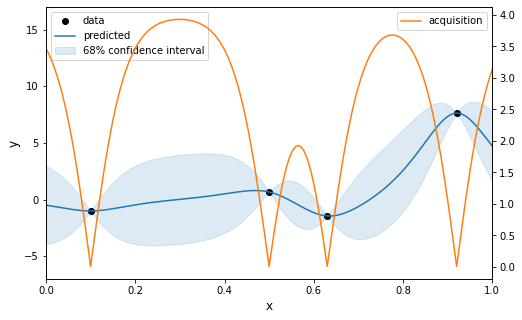

In [33]:
plot(acquisition=σ)

## Thompson sampling
With Thompson sampling (TS) we simply draw a sample of the posterior predictive distribution and optimize it. 
For Gaussian processes there is no known way of sampling *functions*. 
Hence, either a certain number of *points* $x$ sampled from the predictive distribution are considered for the optimiziation, or an approximate *function* sample is used. 

A limitation for the former is that all previously sampled points contribute to the GP posterior when sampling further points, thus the computational complexity for iterative optimization methods grows with $n^3$, where $n$ is the number of iteratiations / evaluations.
A simpler but non-optimal alternative is brute-force optimization over a fixed number of simultaneously sampled points.

For approximate function samples a method called [spectral sampling](gp_spectral_sampling.iypnb) is proposed in [Hernandez-Lobato 2014] and worked out in [Bradford 2018].
The advantage of this method is that the function sample can be evaluated at fixed cost.

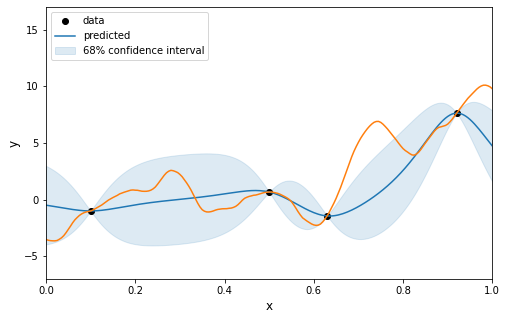

In [31]:
# Thompson sampling using finite sampled points
μ, cov = gp.predict(X, full_cov=True)
rng = np.random.default_rng(seed=42)
y_sample = rng.multivariate_normal(μ.ravel(), cov)
# we would pick the 

plot()
plt.plot(X, y_sample, color="C1");

## Entropy search
In a nutshell entropy search approximates the distribution of the global minimum and tries to best decrease it's entropy.  
$\alpha_{ES}(x) = H(p(x^*|\mathcal{D})) - E[H(p(x^*|\mathcal{D} \cup \{x, y\}))]$ where $x^*$ is the argmax of the global optimum. Since $x^*$ is unknown we need to derive it's distribution via sampling from the posterior.

## Predictive entropy search
$\alpha(x) = H(p(y|D_t,x)) - E[H(p(y|D_t, x, x_*))]$

## Max-value entropy search
The idea is to keep the information-theoretic approach, but reducing the computational complexity by searching for the max $y^*$ instead of the argmax $x^*$.  
$\alpha_\mathrm{MES}(x) = H(p(y|\mathcal{D},x)) - E[H(p(y|\mathcal{D}, x, y_*))]$ where in the left hand term $p$ is a Gaussian, an in the right hand term $p$ is a truncated Gaussian fullfilling $y \leq y^*$  
If the value of $y^*$ is known MES has closed form. If it is unknow it needs to be sampled. Next to sampling from the posterior the authors propose using a Gumbel distribution as approximation.  
$\alpha(x) = (y^* + |\mathcal{N}(0, \sigma)| - \mu_f(x)) / \sigma_f(x)$

## Knowledge gradient
[Frazier+ 2009] [Scott+ 2011]

## Mutual information
[Contal+ 2014]

## GLASSES
[Gonzales+ 2016]

## Estimation strategy
Optimization as Estimation with Gaussian Processes in Bandit Settings [Wang+ 2016]]

## Expected hypervolume improvement
Expected hypervolume improvement (EHVI), also known as S-metric-based expected improvement, is an extension of the expected improvement to multiple objectives. 
It's the expectation value of the improvement in hypervolume for a given candidate $x$ with respect to the existing data $\mathcal{D}$.

The first method to calculate EVHI was Monte Carlo integration [Emmerich 2005], however the accuracy of this method strongly depends on the number of MC samples.
For the 2D case an exact methods was proposed in [Emmerich 2012] with complexity $O(n^3 \log n)$, where $n$ is the number of non-dominated points in the data set.
An exact method for >2D was proposed in [Cockuyt 2014] without an analysis of the complexity.
[Hupkens 2015] introduced a method with complexity of $O(n^2)$ for 2D and $O(n^3)$ for 3D.
Asymptotically optimal algorithms with $O(n \log n)$ complexity were proposed in [Emmerich 2016] for the 2D case, and in [Yang 2017] for the 3D case.
In [Yang 2019] this was extended to >4D and to the probability of improvement on the Pareto front.
Codes are found [here](http://liacs.leidenuniv.nl/~csmoda/).

In [Dalton 2020] a qMC-based parallel EHVI function is proposed and optimized with gradient-based optimizers using auto-differentiation.
The author announced that an implementation in Botorch will follow.

## References

* Auer (2002) Using confidence bounds for exploitation-exploration trade-offs  
  https://dl.acm.org/doi/10.5555/944919.944941
* Srinivas+ (2010) Gaussian Process Optimization in the Bandit Setting: No Regret and Experimental Design  
  https://arxiv.org/abs/0912.3995
* Kushner (1964) A new method of locating the maximum point of an arbitrary multipeak curve in the presence of noise  
  https://fluidsengineering.asmedigitalcollection.asme.org/article.aspx?articleid=1431594
* Mockus (1974) On Bayesian Methods for Seeking the Extremum  
  https://link.springer.com/content/pdf/10.1007/3-540-07165-2_55.pdf
* Qin+ (2017) Improving the Expected Improvement Algorithm  
  https://arxiv.org/abs/1705.10033
* Noe (2018) On a New Improvement-Based Acquisition Function for Bayesian Optimization  
  https://arxiv.org/abs/1808.06918
* Contal+ (2014) Gaussian Process Optimization with Mutual Information  
  http://proceedings.mlr.press/v32/contal14.pdf
* Henning+ (2012) Entropy Search for Information-Efficient Global Optimization  
  https://arxiv.org/abs/1112.1217
* Hernandez-Lobato+ (2014) Predictive Entropy Search for Efficient Global Optimization of Black-box Functions
  https://arxiv.org/abs/1406.2541
* Wang (2018) Max-value Entropy Search for Efficient Bayesian Optimization  
  https://arxiv.org/abs/1703.01968
* Wang+ (2016) Optimization as Estimation with Gaussian Processes in Bandit Settings  
  https://arxiv.org/abs/1510.06423
* Gonzales+ (2016) GLASSES: Relieving The Myopia Of Bayesian Optimisation  
  https://arxiv.org/abs/1510.06299
* Hutter+ (2010) Sequential Model-Based Optimization for General Algorithm Configuration  
  https://doi.org/10.1007/978-3-642-25566-3_40
* Frazier+ (2009) The knowledge-gradient policy for correlated normal beliefs  
  https://pubsonline.informs.org/doi/abs/10.1287/ijoc.1080.0314
* Scott+ (2011) The Correlated Knowledge Gradient for Simulation Optimization of Continuous Parameters using Gaussian Process Regression  
  https://epubs.siam.org/doi/10.1137/100801275
* Emmerich (2005) Single- and Multi-objective Evolutionary Design Optimization Assisted by Gaussian Random Field Metamodels  
  https://d-nb.info/998357294/34
* Svenson+ (2016) Multiobjective optimization of expensive-to-evaluate deterministic computer simulator models  
  https://www.sciencedirect.com/science/article/pii/S0167947315001991
* Keane (2012) Statistical Improvement Criteria for Use in Multiobjective Design Optimization  
  https://arc.aiaa.org/doi/abs/10.2514/1.16875?journalCode=aiaaj
* Garrido-Merchan+ (2019) Predictive Entropy Search for Multi-objective Bayesian Optimization with Constraints  
  https://www.sciencedirect.com/science/article/pii/S0925231219308525
* Picheny (2015) Multiobjective optimization using Gaussian process emulators via stepwise uncertainty reduction  
  https://link.springer.com/article/10.1007/s11222-014-9477-x
* Bradford (2018) Efficient multiobjective optimization employing Gaussian processes, spectral sampling and a genetic algorithm  
  https://doi.org/10.1007/s10898-018-0609-2
* Deutz (2019) Expected R2 Indicator Improvement as an Infill Criterion in Bi-objective Bayesian Optimization  
  https://link.springer.com/chapter/10.1007/978-3-030-12598-1_29
* Zachary+ (2019) Assessing the Frontier: Active Learning, Model Accuracy, and Multi-objective Materials Discovery and Optimization  
  https://arxiv.org/abs/1911.03224
* Emmerich+ (2012) Hypervolume-based expected improvement: monotonicity properties and exact computation  
  https://ieeexplore.ieee.org/abstract/document/5949880
* Couckuyt+ (2014) Fast calculation of multiobjective probability of improvement and expected improvement criteria for Pareto optimization  
  https://link.springer.com/article/10.1007/s10898-013-0118-2
* Hupkens+ (2015) Faster exact algorithms for computing expected hypervolume improvement  
  https://link.springer.com/chapter/10.1007/978-3-319-15892-1_5
* Emmerich+ (2016) A multicriteria generalization of Bayesian global optimization  
  https://link.springer.com/chapter/10.1007/978-3-319-29975-4_12
* Yang+ (2017) Computing 3-D expected hypervolume improvement and related integrals in asymptotically optimal time  
  https://link.springer.com/chapter/10.1007/978-3-319-54157-0_46
* Yang+ (2019) Efficient computation of expected hypervolume improvement using box decomposition algorithms  
  https://link.springer.com/article/10.1007/s10898-019-00798-7* Dalton+ (2020) Differentiable Expected Hypervolume Improvement for Parallel Multi-Objective Bayesian Optimization  
  https://https://arxiv.org/abs/2006.05078